## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

## Transformations

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(size=244),
    transforms.CenterCrop(size=244),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [3]:
test_transform = transforms.Compose([
    transforms.Resize(size=244),
    transforms.CenterCrop(size=244),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

## Loading Dataset

In [4]:
data_directory = 'data/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(data_directory, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_directory, 'test'), transform=test_transform)

In [5]:
train_data

Dataset ImageFolder
    Number of datapoints: 18743
    Root location: data/CATS_DOGS/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=244, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(244, 244))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
test_data

Dataset ImageFolder
    Number of datapoints: 6251
    Root location: data/CATS_DOGS/test
    StandardTransform
Transform: Compose(
               Resize(size=244, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(244, 244))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=False)

In [8]:
class_names = train_data.classes
class_names

['CAT', 'DOG']

## Examine Batch of Images

In [9]:
for images, labels in train_loader:
    break

In [10]:
images.shape

torch.Size([10, 3, 244, 244])

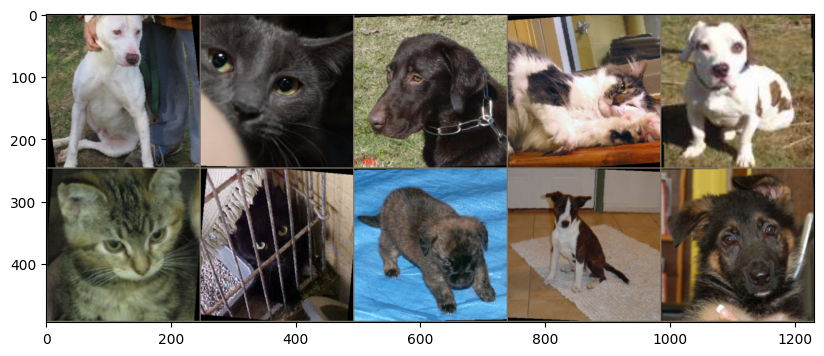

In [11]:
img = make_grid(images, nrow=5)

inverse_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

inverse_img = inverse_transform(img)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(inverse_img.numpy(), (1, 2, 0)))

## Using Pretrained Model

In [19]:
alexnet_model = models.alexnet(pretrained=True)

In [20]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
parameter_list = []
for param in alexnet_model.parameters():
    parameter_list.append(param.numel())

print(f"Total Number of Parameters: {sum(parameter_list)}")

Total Number of Parameters: 61100840


## Freeze Certain Parameters

In [24]:
for param in alexnet_model.parameters():
    param.requires_grad = False

## Modify the Classifier

In [26]:
torch.manual_seed(42)

alexnet_model.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=2),
    nn.LogSoftmax(dim=1)
)

alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [27]:
parameter_list = []
for param in alexnet_model.parameters():
    parameter_list.append(param.numel())

print(f"Total Number of Parameters: {sum(parameter_list)}")

Total Number of Parameters: 11909954


## Training the Model

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet_model.classifier.parameters(), lr=0.001)

In [30]:
import time
start_time = time.time()

epochs = 2
max_train_batch = 800
max_test_batch = 300

train_losses_list = []
test_losses_list = []
train_correct_list = []
test_correct_list = []

for i in range(epochs):
    train_correct = 0
    test_correct = 0

    for batch, (X_train, y_train) in enumerate(train_loader):
        if batch == max_train_batch:
            break
            
        batch += 1
        y_pred = alexnet_model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 200 == 0:
            print(f"EPOCH: {i} BATCH: {batch} LOSS: {loss.item()} ACCURACY: {train_correct.item()*100/(batch*10):7.3f}%")

    train_losses_list.append(loss.detach().numpy())
    train_correct_list.append(train_correct)

    # Testing
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            if batch == max_test_batch:
                break
            
            y_val = alexnet_model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses_list.append(loss.detach().numpy())
    test_correct_list.append(test_correct)


current_time = time.time()
total_time = current_time - start_time
print(f"Training Took {total_time/60} minutes")

EPOCH: 0 BATCH: 200 LOSS: 1.2370264530181885 ACCURACY:  88.900%
EPOCH: 0 BATCH: 400 LOSS: 0.13409027457237244 ACCURACY:  90.375%
EPOCH: 0 BATCH: 600 LOSS: 0.07342824339866638 ACCURACY:  91.350%
EPOCH: 0 BATCH: 800 LOSS: 0.00205791974440217 ACCURACY:  92.237%
EPOCH: 1 BATCH: 200 LOSS: 0.16647008061408997 ACCURACY:  94.150%
EPOCH: 1 BATCH: 400 LOSS: 0.011011376976966858 ACCURACY:  93.725%
EPOCH: 1 BATCH: 600 LOSS: 0.004596593789756298 ACCURACY:  94.000%
EPOCH: 1 BATCH: 800 LOSS: 0.05257898569107056 ACCURACY:  93.987%
Training Took 2.421797768274943 minutes


In [38]:
test_correct.item() / 3000

0.9563333333333334

## Passing the Image

In [39]:
inverse_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [40]:
image_index = 2019

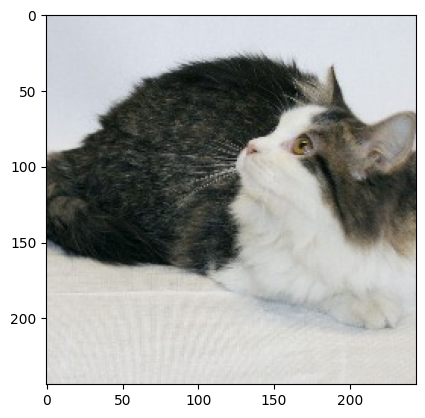

In [42]:
im = inverse_transform(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [43]:
alexnet_model.eval()

with torch.no_grad():
    new_prediction = alexnet_model(test_data[image_index][0].view(1, 3, 244, 244)).argmax()

class_names[new_prediction.item()]

'CAT'